In [309]:
import os
import numpy as np
import pandas as pd
import chardet
import matplotlib.pyplot as plt
from pmdarima.arima import auto_arima
import pickle
import copy
from datetime import datetime, timedelta

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.impute import KNNImputer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score

from scipy.stats import uniform
from scipy.stats import randint as sp_randint

from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
import statsmodels.api as sm
import statsmodels.tsa.stattools as sts

import warnings

if str(os.getcwdb()[-3:]).split("'")[1] != 'src':
    for _ in range(2):
        os.chdir(os.path.dirname(os.getcwdb()))

from utils.classes import *


# Preparación de los datos

In [310]:
# Se comprueba el "encoding" de los csv mediante chardet
with open('data/raw/Ruido_diario_acumulado.csv', 'rb') as f:
    result = chardet.detect(f.read())
    
result


{'encoding': 'ascii', 'confidence': 1.0, 'language': ''}

In [311]:
# Se obtienen los datos
df_acoustics = pd.read_csv('data/raw/Ruido_diario_acumulado.csv', encoding=result['encoding'], delimiter=';')

len(df_acoustics)


389519

In [312]:
# Se borran los datos no necesarios
df_acoustics = df_acoustics.drop(columns=['LAEQ', 'LAS01', 'LAS10', 'LAS90', 'LAS99'])

df_acoustics.head()


,NMT,anio,mes,dia,tipo,LAS50
0,3,2014,1,1,D,"54,3"
1,3,2014,1,1,E,56
2,3,2014,1,1,N,"60,9"
3,3,2014,1,1,T,"56,5"
4,4,2014,1,1,D,"63,2"


In [313]:
# Se mantiene solo el tipo "T", que representa el total del día
df_acoustics = df_acoustics.drop(df_acoustics[df_acoustics['tipo'] != 'T'].index)

df_acoustics = df_acoustics.drop(columns='tipo')

df_acoustics.head()


,NMT,anio,mes,dia,LAS50
3,3,2014,1,1,"56,5"
7,4,2014,1,1,"63,9"
11,5,2014,1,1,"58,6"
15,8,2014,1,1,"65,2"
19,10,2014,1,1,"58,7"


In [314]:
for date in df_acoustics.columns[1:-1]:
    df_acoustics[date] = list(map(str, df_acoustics[date]))

df_acoustics['date'] = df_acoustics['anio'] + '-' + df_acoustics['mes'] + '-' + df_acoustics['dia']

df_acoustics = df_acoustics.drop(columns=['anio', 'mes', 'dia'])

df_acoustics.head()


,NMT,LAS50,date
3,3,"56,5",2014-1-1
7,4,"63,9",2014-1-1
11,5,"58,6",2014-1-1
15,8,"65,2",2014-1-1
19,10,"58,7",2014-1-1


In [315]:
# Se convierte la columna "Fecha" al formato "datetime" y se pasa al índice
df_acoustics['date'] = pd.to_datetime(df_acoustics['date'])

df_acoustics = df_acoustics.set_index('date')
df_acoustics = df_acoustics.sort_index()

df_acoustics.index


DatetimeIndex(['2014-01-01', '2014-01-01', '2014-01-01', '2014-01-01',
               '2014-01-01', '2014-01-01', '2014-01-01', '2014-01-01',
               '2014-01-01', '2014-01-01',
               ...
               '2023-03-20', '2023-03-20', '2023-03-20', '2023-03-20',
               '2023-03-20', '2023-03-20', '2023-03-20', '2023-03-20',
               '2023-03-20', '2023-03-20'],
              dtype='datetime64[ns]', name='date', length=97522, freq=None)

In [316]:
# Se pasan a numéricos los no nulos de todas las columnas, y las "string" que representan los nulos se convierten en nulos reales
df_acoustics['LAS50'] = df_acoustics['LAS50'].astype(str)

for col in df_acoustics.columns[1:]:
    df_acoustics[col] = df_acoustics[col].apply(lambda x: ''.join([number.replace(',', '.') if ',' in number else number for number in x]))
    df_acoustics[col] = pd.to_numeric(df_acoustics[col], errors='coerce')
    df_acoustics[col] = df_acoustics[col].astype(float)

df_acoustics.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 97522 entries, 2014-01-01 to 2023-03-20
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   NMT     97522 non-null  int64  
 1   LAS50   97522 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 2.2 MB


In [317]:
# Se pivota la tabla para que cada columna sea una zona
df_acoustics = df_acoustics.pivot_table(index='date', columns='NMT', values='LAS50')

df_acoustics.head()


NMT,1,2,3,4,5,6,8,10,11,12,13,14,16,17,18,19,20,24,25,26,27,28,29,30,31,47,48,50,54,55,86
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-01-01,NaN,NaN,56.5,63.9,58.6,NaN,65.2,58.7,65.4,60.3,54.0,63.5,58.9,50.1,47.9,57.5,57.7,44.6,NaN,NaN,50.3,60.0,49.0,51.9,52.6,47.8,60.3,NaN,56.2,48.1,50.5
2014-01-02,NaN,NaN,58.0,64.8,60.0,NaN,67.5,61.7,69.1,62.7,54.9,65.8,61.9,52.7,49.7,59.4,60.2,46.2,NaN,NaN,52.1,62.8,51.2,59.7,58.9,51.0,62.7,NaN,60.9,51.6,54.3
2014-01-03,NaN,NaN,58.6,64.7,60.0,NaN,67.2,61.9,69.1,62.4,55.2,65.4,61.9,52.8,50.8,59.5,60.3,45.6,NaN,NaN,51.7,63.5,52.6,58.5,58.9,50.5,62.7,NaN,60.6,50.9,54.0
2014-01-04,NaN,NaN,59.0,64.2,59.3,NaN,67.1,60.3,67.4,61.7,55.3,64.5,60.4,54.1,49.6,59.5,59.9,47.0,NaN,NaN,53.3,61.9,50.4,55.8,60.0,51.1,62.0,NaN,60.1,50.9,52.8
2014-01-05,NaN,NaN,58.0,63.4,57.8,NaN,64.9,58.9,66.1,60.5,53.2,63.3,59.0,50.0,47.6,57.4,57.4,44.3,NaN,NaN,48.4,59.8,48.7,52.7,56.9,47.1,60.1,NaN,58.3,47.9,50.5


In [318]:
# Se establece la frecuencia "D" (diaria)
df_acoustics = df_acoustics.asfreq('D')

df_acoustics.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3366 entries, 2014-01-01 to 2023-03-20
Freq: D
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1       2820 non-null   float64
 1   2       2902 non-null   float64
 2   3       3243 non-null   float64
 3   4       2456 non-null   float64
 4   5       3279 non-null   float64
 5   6       2884 non-null   float64
 6   8       3218 non-null   float64
 7   10      3254 non-null   float64
 8   11      3206 non-null   float64
 9   12      3276 non-null   float64
 10  13      3274 non-null   float64
 11  14      3209 non-null   float64
 12  16      3190 non-null   float64
 13  17      3261 non-null   float64
 14  18      3257 non-null   float64
 15  19      3168 non-null   float64
 16  20      3234 non-null   float64
 17  24      3246 non-null   float64
 18  25      2869 non-null   float64
 19  26      2869 non-null   float64
 20  27      3216 non-null   float64
 21  28      327

In [319]:
# El resto, con una interpolación. Sigue habiendo nulos
df_acoustics = df_acoustics.interpolate(method='spline', order=3)

df_acoustics.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3366 entries, 2014-01-01 to 2023-03-20
Freq: D
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1       3001 non-null   float64
 1   2       3000 non-null   float64
 2   3       3366 non-null   float64
 3   4       3366 non-null   float64
 4   5       3366 non-null   float64
 5   6       3000 non-null   float64
 6   8       3366 non-null   float64
 7   10      3366 non-null   float64
 8   11      3366 non-null   float64
 9   12      3366 non-null   float64
 10  13      3366 non-null   float64
 11  14      3366 non-null   float64
 12  16      3366 non-null   float64
 13  17      3366 non-null   float64
 14  18      3366 non-null   float64
 15  19      3366 non-null   float64
 16  20      3366 non-null   float64
 17  24      3366 non-null   float64
 18  25      3001 non-null   float64
 19  26      3001 non-null   float64
 20  27      3366 non-null   float64
 21  28      336

In [320]:
# Se imputan los restantes con los vecinos cercanos
imputer = KNNImputer(n_neighbors=5)

imputer.fit(df_acoustics)

df_acoustics = pd.DataFrame(imputer.transform(df_acoustics), columns=df_acoustics.columns, index=df_acoustics.index)

df_acoustics.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3366 entries, 2014-01-01 to 2023-03-20
Freq: D
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1       3366 non-null   float64
 1   2       3366 non-null   float64
 2   3       3366 non-null   float64
 3   4       3366 non-null   float64
 4   5       3366 non-null   float64
 5   6       3366 non-null   float64
 6   8       3366 non-null   float64
 7   10      3366 non-null   float64
 8   11      3366 non-null   float64
 9   12      3366 non-null   float64
 10  13      3366 non-null   float64
 11  14      3366 non-null   float64
 12  16      3366 non-null   float64
 13  17      3366 non-null   float64
 14  18      3366 non-null   float64
 15  19      3366 non-null   float64
 16  20      3366 non-null   float64
 17  24      3366 non-null   float64
 18  25      3366 non-null   float64
 19  26      3366 non-null   float64
 20  27      3366 non-null   float64
 21  28      336

# ML

### Un solo barrio

#### Preparación

In [321]:
# Se selecciona solo el primer barrio
df_uno = df_acoustics[[1]]

df_uno.head()


NMT,1
date,
2014-01-01,64.60
2014-01-02,66.62
2014-01-03,66.82
2014-01-04,65.66
2014-01-05,64.26


In [322]:
# Se le cambia el nombre
df_uno = df_uno.rename(columns={1: 'x'})

df_uno.head()


NMT,x
date,
2014-01-01,64.60
2014-01-02,66.62
2014-01-03,66.82
2014-01-04,65.66
2014-01-05,64.26


In [323]:
# Se crean columnas sucesivas que incluyen los decibelios de las fechas anteriores para cada índice
n = len(df_uno)

for i in range(n+1):
    df_uno[f'x-{i}'] = df_uno['x'].shift(i)

df_uno


NMT             x    x-0    x-1    x-2    x-3   x-4   x-5   x-6   x-7   x-8  \
date                                                                          
2014-01-01  64.60  64.60    NaN    NaN    NaN   NaN   NaN   NaN   NaN   NaN   
2014-01-02  66.62  66.62  64.60    NaN    NaN   NaN   NaN   NaN   NaN   NaN   
2014-01-03  66.82  66.82  66.62  64.60    NaN   NaN   NaN   NaN   NaN   NaN   
2014-01-04  65.66  65.66  66.82  66.62  64.60   NaN   NaN   NaN   NaN   NaN   
2014-01-05  64.26  64.26  65.66  66.82  66.62  64.6   NaN   NaN   NaN   NaN   
...           ...    ...    ...    ...    ...   ...   ...   ...   ...   ...   
2023-03-16  62.00  62.00  61.90  61.30  61.00  60.3  61.6  62.2  62.9  62.2   
2023-03-17  62.00  62.00  62.00  61.90  61.30  61.0  60.3  61.6  62.2  62.9   
2023-03-18  60.60  60.60  62.00  62.00  61.90  61.3  61.0  60.3  61.6  62.2   
2023-03-19  59.00  59.00  60.60  62.00  62.00  61.9  61.3  61.0  60.3  61.6   
2023-03-20  58.50  58.50  59.00  60.60  62.00  62.0  61.9  61.3  61.0  60.3   

NMT          x-9  x-10  x-11  x-12  x-13  x-14  x-15  x-16  x-17  x-18  x-19  \
date                                                                           
2014-01-01   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2014-01-02   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2014-01-03   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2014-01-04   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2014-01-05   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
...          ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
2023-03-16  62.1  61.8  60.3  60.8  62.3  61.6  61.2  61.0  60.7  59.7  61.1   
2023-03-17  62.2  62.1  61.8  60.3  60.8  62.3  61.6  61.2  61.0  60.7  59.7   
2023-03-18  62.9  62.2  62.1  61.8  60.3  60.8  62.3  61.6  61.2  61.0  60.7   
2023-03-19  62.2  62.9  62.2  62.1  61.8  60.3  60.8  62.3  61.6  61.2  61.0   
2023-03-20  61.6  62.2  62.9  62.2  62.1  61.8  60.3  60.8  62.3  61.6  61.2   

NMT         x-20  x-21  x-22  x-23  x-24  x-25  x-26  x-27  x-28  x-29  x-30  \
date                                                                           
2014-01-01   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2014-01-02   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2014-01-03   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2014-01-04   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2014-01-05   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
...          ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
2023-03-16  62.1  61.6  61.2  60.7  60.9  59.3  60.8  61.8  61.9  61.7  61.6   
2023-03-17  61.1  62.1  61.6  61.2  60.7  60.9  59.3  60.8  61.8  61.9  61.7   
2023-03-18  59.7  61.1  62.1  61.6  61.2  60.7  60.9  59.3  60.8  61.8  61.9   
2023-03-19  60.7  59.7  61.1  62.1  61.6  61.2  60.7  60.9  59.3  60.8  61.8   
2023-03-20  61.0  60.7  59.7  61.1  62.1  61.6  61.2  60.7  60.9  59.3  60.8   

NMT         x-31  x-32  x-33  x-34  x-35  x-36  x-37  x-38  x-39  x-40  x-41  \
date                                                                           
2014-01-01   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2014-01-02   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2014-01-03   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2014-01-04   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2014-01-05   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
...          ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
2023-03-16  61.5  60.3  61.3  62.0  61.7  62.1  61.0  60.9  58.5  61.0  63.1   
2023-03-17  61.6  61.5  60.3  61.3  62.0  61.7  62.1  61.0  60.9  58.5  61.0   
2023-03-18  61.7  61.6  61.5  60.3  61.3  62.0  61.7  62.1  61.0  60.9  58.5   
2023-03-19

In [324]:
# Se ordenan de mas reciente a mas antiguo
df_uno = df_uno.sort_index(ascending=False)
df_uno = df_uno.drop(columns='x-0')

df_uno.head()


NMT,x,x-1,x-2,x-3,x-4,x-5,x-6,x-7,x-8,x-9,x-10,x-11,x-12,x-13,x-14,x-15,x-16,x-17,x-18,x-19,x-20,x-21,x-22,x-23,x-24,x-25,x-26,x-27,x-28,x-29,x-30,x-31,x-32,x-33,x-34,x-35,x-36,x-37,x-38,x-39,x-40,x-41,x-42,x-43,x-44,x-45,x-46,x-47,x-48,x-49,x-50,x-51,x-52,x-53,x-54,x-55,x-56,x-57,x-58,x-59,x-60,x-61,x-62,x-63,x-64,x-65,x-66,x-67,x-68,x-69,x-70,x-71,x-72,x-73,x-74,x-75,x-76,x-77,x-78,x-79,x-80,x-81,x-82,x-83,x-84,x-85,x-86,x-87,x-88,x-89,x-90,x-91,x-92,x-93,x-94,x-95,x-96,x-97,x-98,x-99,x-100,x-101,x-102,x-103,x-104,x-105,x-106,x-107,x-108,x-109,x-110,x-111,x-112,x-113,x-114,x-115,x-116,x-117,x-118,x-119,x-120,x-121,x-122,x-123,x-124,x-125,x-126,x-127,x-128,x-129,x-130,x-131,x-132,x-133,x-134,x-135,x-136,x-137,x-138,x-139,x-140,x-141,x-142,x-143,x-144,x-145,x-146,x-147,x-148,x-149,x-150,x-151,x-152,x-153,x-154,x-155,x-156,x-157,x-158,x-159,x-160,x-161,x-162,x-163,x-164,x-165,x-166,x-167,x-168,x-169,x-170,x-171,x-172,x-173,x-174,x-175,x-176,x-177,x-178,x-179,x-180,x-181,x-182,x-183,x-184,x-185,x-186,x-187,x-188,x-189,x-190,x-191,x-192,x-193,x-194,x-195,x-196,x-197,x-198,x-199,x-200,x-201,x-202,x-203,x-204,x-205,x-206,x-207,x-208,x-209,x-210,x-211,x-212,x-213,x-214,x-215,x-216,x-217,x-218,x-219,x-220,x-221,x-222,x-223,x-224,x-225,x-226,x-227,x-228,x-229,x-230,x-231,x-232,x-233,x-234,x-235,x-236,x-237,x-238,x-239,x-240,x-241,x-242,x-243,x-244,x-245,x-246,x-247,x-248,x-249,x-250,x-251,x-252,x-253,x-254,x-255,x-256,x-257,x-258,x-259,x-260,x-261,x-262,x-263,x-264,x-265,x-266,x-267,x-268,x-269,x-270,x-271,x-272,x-273,x-274,x-275,x-276,x-277,x-278,x-279,x-280,x-281,x-282,x-283,x-284,x-285,x-286,x-287,x-288,x-289,x-290,x-291,x-292,x-293,x-294,x-295,x-296,x-297,x-298,x-299,x-300,x-301,x-302,x-303,x-304,x-305,x-306,x-307,x-308,x-309,x-310,x-311,x-312,x-313,x-314,x-315,x-316,x-317,x-318,x-319,x-320,x-321,x-322,x-323,x-324,x-325,x-326,x-327,x-328,x-329,x-330,x-331,x-332,x-333,x-334,x-335,x-336,x-337,x-338,x-339,x-340,x-341,x-342,x-343,x-344,x-345,x-346,x-347,x-348,x-349,x-350,x-351,x-352,x-353,x-354,x-355,x-356,x-357,x-358,x-359,x-360,x-361,x-362,x-363,x-364,x-365,x-366,x-367,x-368,x-369,x-370,x-371,x-372,x-373,x-374,x-375,x-376,x-377,x-378,x-379,x-380,x-381,x-382,x-383,x-384,x-385,x-386,x-387,x-388,x-389,x-390,x-391,x-392,x-393,x-394,x-395,x-396,x-397,x-398,x-399,x-400,x-401,x-402,x-403,x-404,x-405,x-406,x-407,x-408,x-409,x-410,x-411,x-412,x-413,x-414,x-415,x-416,x-417,x-418,x-419,x-420,x-421,x-422,x-423,x-424,x-425,x-426,x-427,x-428,x-429,x-430,x-431,x-432,x-433,x-434,x-435,x-436,x-437,x-438,x-439,x-440,x-441,x-442,x-443,x-444,x-445,x-446,x-447,x-448,x-449,x-450,x-451,x-452,x-453,x-454,x-455,x-456,x-457,x-458,x-459,x-460,x-461,x-462,x-463,x-464,x-465,x-466,x-467,x-468,x-469,x-470,x-471,x-472,x-473,x-474,x-475,x-476,x-477,x-478,x-479,x-480,x-481,x-482,x-483,x-484,x-485,x-486,x-487,x-488,x-489,x-490,x-491,x-492,x-493,x-494,x-495,x-496,x-497,x-498,x-499,...,x-2867,x-2868,x-2869,x-2870,x-2871,x-2872,x-2873,x-2874,x-2875,x-2876,x-2877,x-2878,x-2879,x-2880,x-2881,x-2882,x-2883,x-2884,x-2885,x-2886,x-2887,x-2888,x-2889,x-2890,x-2891,x-2892,x-2893,x-2894,x-2895,x-2896,x-2897,x-2898,x-2899,x-2900,x-2901,x-2902,x-2903,x-2904,x-2905,x-2906,x-2907,x-2908,x-2909,x-2910,x-2911,x-2912,x-2913,x-2914,x-2915,x-2916,x-2917,x-2918,x-2919,x-2920,x-2921,x-2922,x-2923,x-2924,x-2925,x-2926,x-2927,x-2928,x-2929,x-2930,x-2931,x-2932,x-2933,x-2934,x-2935,x-2936,x-2937,x-2938,x-2939,x-2940,x-2941,x-2942,x-2943,x-2944,x-2945,x-2946,x-2947,x-2948,x-2949,x-2950,x-2951,x-2952,x-2953,x-2954,x-2955,x-2956,x-2957,x-2958,x-2959,x-2960,x-2961,x-2962,x-2963,x-2964,x-2965,x-2966,x-2967,x-2968,x-2969,x-2970,x-2971,x-2972,x-2973,x-2974,x-2975,x-2976,x-2977,x-2978,x-2979,x-2980,x-2981,x-2982,x-2983,x-2984,x-2985,x-2986,x-2987,x-2988,x-2989,x-2990,x-2991,x-2992,x-2993,x-2994,x-2995,x-2996,x-2997,x-2998,x-2999,x-3000,x-3001,x-3002,x-3003,x-3004,x-3005,x-3006,x-3007,x-3008,x-3009,x-3010,x-3011,x-3012,x-3013,x-3014,x-3015,x-3016,x-3017,x-3018,x-3019,x-3020,x-3021,x-3022,x-3023,x-302

In [325]:
# Se guardan las primeras 7 para preservar la estacionalidad semanal
df_uno_shortened = df_uno[df_uno.columns[:8]].dropna()

df_uno_shortened.head()


NMT,x,x-1,x-2,x-3,x-4,x-5,x-6,x-7
date,,,,,,,,
2023-03-20,58.5,59.0,60.6,62.0,62.0,61.9,61.3,61.0
2023-03-19,59.0,60.6,62.0,62.0,61.9,61.3,61.0,60.3
2023-03-18,60.6,62.0,62.0,61.9,61.3,61.0,60.3,61.6
2023-03-17,62.0,62.0,61.9,61.3,61.0,60.3,61.6,62.2
2023-03-16,62.0,61.9,61.3,61.0,60.3,61.6,62.2,62.9


#### Baseline

In [326]:
# Se eligen los modelos a probar
Regression.add_models('LinearRegression',
                        'Ridge',
                        'DecisionTreeRegressor',
                        'KNeighborsRegressor',
                        'RandomForestRegressor',
                        'XGBRegressor'
                        )

Regression.chosen_models


{'LinearRegression': '',
 'Ridge': '',
 'DecisionTreeRegressor': '',
 'KNeighborsRegressor': '',
 'RandomForestRegressor': '',
 'XGBRegressor': ''}

In [327]:
# Se hace el baseline
baseline = Regression(df_uno_shortened, 'x')
X_train, X_test, y_train, y_test = baseline.split_dataframe()
baseline.prepare_models(params_list=[['DecisionTreeRegressor', 'random_state=43'],
                                    ['RandomForestRegressor', 'random_state=43'],
                                    ['XGBRegressor', 'random_state=43'],
                                    ]
                        )
baseline_dict = baseline.apply_and_evaluate_kfolds()
baseline.create_dataframe()


-- Regression: using mean of 5 folds --
Starting LinearRegression:
- LinearRegression done in 0.08 sec(s). Total time: 0.08
Starting Ridge:
- Ridge done in 0.06 sec(s). Total time: 0.14
Starting KNeighborsRegressor:
- KNeighborsRegressor done in 0.11 sec(s). Total time: 0.25
Starting DecisionTreeRegressor: random_state=43:
- DecisionTreeRegressor: random_state=43 done in 0.16 sec(s). Total time: 0.42
Starting RandomForestRegressor: random_state=43:
- RandomForestRegressor: random_state=43 done in 12.91 sec(s). Total time: 13.33
Starting XGBRegressor: random_state=43:
- XGBRegressor: random_state=43 done in 0.86 sec(s). Total time: 14.18


,LinearRegression,Ridge,KNeighborsRegressor,DecisionTreeRegressor: random_state=43,RandomForestRegressor: random_state=43,XGBRegressor: random_state=43,BEST,WORST
rmse,1.232422,1.232418,1.226251,1.609918,1.179524,1.229443,RandomForestRegressor: random_state=43,DecisionTreeRegressor: random_state=43
mse,1.529045,1.529036,1.516342,2.594167,1.403415,1.519021,RandomForestRegressor: random_state=43,DecisionTreeRegressor: random_state=43
mae,0.843539,0.843530,0.790196,1.050900,0.764248,0.833945,RandomForestRegressor: random_state=43,DecisionTreeRegressor: random_state=43
r2_score,0.798639,0.798640,0.800578,0.656143,0.815472,0.799878,RandomForestRegressor: random_state=43,XGBRegressor: random_state=43
mape,0.013498,0.013498,0.012689,0.016787,0.012256,0.013347,RandomForestRegressor: random_state=43,DecisionTreeRegressor: random_state=43


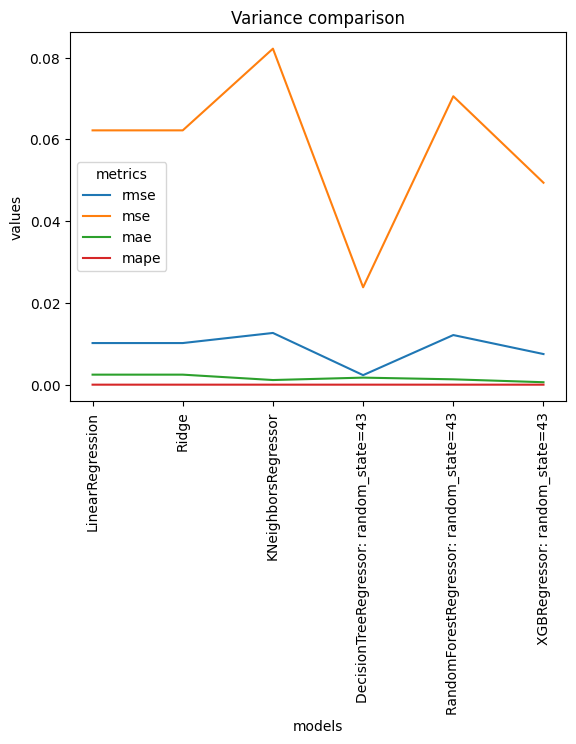

In [328]:
# Se visualiza la varianza entre los "folds"
baseline.create_dataframe(chosen_format='variance')
baseline.visualize('rmse', 'mse', 'mae', 'mape')


### Todos los barrios

#### Preparación

In [329]:
# Se hace lo que en la preparación anterior, pero con todos los barrios, y se guardan los dataframes resultantes en un dicccionario
warnings.filterwarnings("ignore")

dict_df = dict()
for col in df_acoustics.columns:
    df_uno = df_acoustics[[col]]
    df_uno = df_uno.rename(columns={col: 'x'})
    n = len(df_uno)
    for i in range(n+1):
        df_uno[f'x-{i}'] = df_uno['x'].shift(i)
    df_uno = df_uno.sort_index(ascending=False)
    df_uno = df_uno.drop(columns='x-0')
    df_uno_shortened = df_uno[df_uno.columns[:8]].dropna()
    dict_df[col] = df_uno_shortened

dict_df[1].head()


NMT,x,x-1,x-2,x-3,x-4,x-5,x-6,x-7
date,,,,,,,,
2023-03-20,58.5,59.0,60.6,62.0,62.0,61.9,61.3,61.0
2023-03-19,59.0,60.6,62.0,62.0,61.9,61.3,61.0,60.3
2023-03-18,60.6,62.0,62.0,61.9,61.3,61.0,60.3,61.6
2023-03-17,62.0,62.0,61.9,61.3,61.0,60.3,61.6,62.2
2023-03-16,62.0,61.9,61.3,61.0,60.3,61.6,62.2,62.9


In [330]:
with open('data/processed/dict_dfs.pkl', 'wb') as f:
    pickle.dump(dict_df, f)


In [331]:
with open('data/processed/dict_dfs.pkl', 'rb') as f:
    dict_df = pickle.load(f)

dict_df[1].head()


NMT,x,x-1,x-2,x-3,x-4,x-5,x-6,x-7
date,,,,,,,,
2023-03-20,58.5,59.0,60.6,62.0,62.0,61.9,61.3,61.0
2023-03-19,59.0,60.6,62.0,62.0,61.9,61.3,61.0,60.3
2023-03-18,60.6,62.0,62.0,61.9,61.3,61.0,60.3,61.6
2023-03-17,62.0,62.0,61.9,61.3,61.0,60.3,61.6,62.2
2023-03-16,62.0,61.9,61.3,61.0,60.3,61.6,62.2,62.9


#### Predicción

In [332]:
kfolds = KFold(n_splits=2, shuffle=True, random_state=43)

param_grid = {
    'max_depth': range(3, 10),
    'learning_rate': np.linspace(0.01, 0.3, 30),
    'n_estimators': range(50, 200, 10),
    'gamma': np.linspace(0.01, 1.0, 10),
    'subsample': np.linspace(0.5, 1.0, 6),
    'colsample_bytree': np.linspace(0.5, 1.0, 6)
}


In [333]:
for col in df_acoustics.columns:
    df_zone = dict_df[col]
    
    for _ in range(287):
        X = df_zone.drop(columns='x')
        y = df_zone['x']
        last_date = list(map(str, X.index))[0].split()[0]
        X_train = X.drop(index=last_date)
        X_test = X[X.index == last_date]
        y_train = y.drop(index=last_date)
        y_test = y[y.index == last_date]

        model = XGBRegressor()
        model.fit(X_train, y_train)
        pred = model.predict(X_test)

        new_date = datetime.strptime(last_date, '%Y-%m-%d')
        new_date = new_date + timedelta(days=1)

        new_row = pd.DataFrame({'x': pred, 
                                'x-1': df_zone.loc[last_date][0],
                                'x-2': df_zone.loc[last_date][1],
                                'x-3': df_zone.loc[last_date][2],
                                'x-4': df_zone.loc[last_date][3],
                                'x-5': df_zone.loc[last_date][4],
                                'x-6': df_zone.loc[last_date][5],
                                'x-7': df_zone.loc[last_date][6],
                                }, 
                                index=[new_date])
        df_zone = pd.concat([new_row, df_zone.loc[:]])
    break


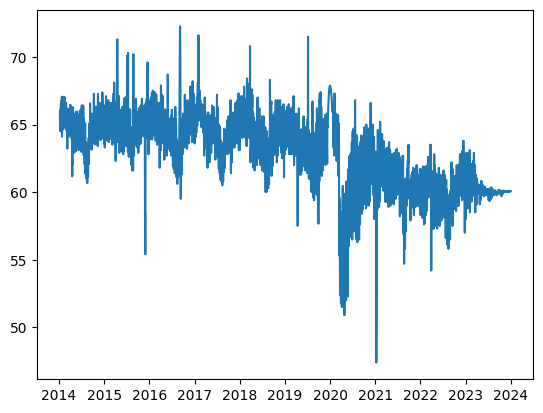

In [334]:
plt.plot(df_zone['x'])
